In [102]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

# read the data from csv file
df = pd.read_csv('train.csv')

# drop these because they shouldn't matter (name) or have too many missing values (cabin)
df.drop(axis=1, labels=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

# count how many missing values per column
# print(df.isna().sum())

# drop the two empty rows with embarked missing
df.dropna(axis=0, subset=['Embarked'], inplace=True)

# There are 177 missing values for age. Guess age based on Parch number (number of parents/child on board).
# Age should be somewhat related to number of parents and children aboard.
# Logically, if someone's a child/teen, you'd expect the parents to be aboard. The older someone is, the more children you'd expect them to have.
avg_age_by_parch = df.groupby(['Parch'])['Age'].mean().to_dict()
print(f'average age for Parch: \n {avg_age_by_parch}')

# Fill in missing age values based on Parch.
def fill_missing_age(row):
    if math.isnan(row.Age):
        parch = row.Parch
        row.Age = avg_age_by_parch[parch]
    return row

df = df.transform(lambda row: fill_missing_age(row), axis=1)

# print(df.isna().sum())

# Transform categorical variables with one-hot encoding
df = pd.get_dummies(data=df, columns=['Sex', 'Pclass', 'Embarked'])

X = df.drop(axis=1, labels=['Survived'])
y = df['Survived'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


average age for Parch: 
 {0: 32.10982658959538, 1: 24.422, 2: 17.216911764705884, 3: 33.2, 4: 44.5, 5: 39.2, 6: 43.0}


In [136]:
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(solver='saga', max_iter=5000, random_state=0)

param_grid = { 'penalty': ['none', 'l1', 'l2'], 'C': [0.05, 0.1, 0.5, 1, 5] }

grid_search = GridSearchCV(clf, param_grid=param_grid)

grid_search.fit(X, y)

result = grid_search.cv_results_
estimator = grid_search.best_estimator_
score = grid_search.best_score_
params = grid_search.best_params_

print('result', result)
print('best score', score)
print('best params', params)


/Users/yilingchen/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/yilingchen/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/yilingchen/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/yilingchen/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/yilingchen/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/yilingchen/anaconda3/lib/python3.8/sit

result {'mean_fit_time': array([0.37842979, 0.37802057, 0.29810033, 0.3804461 , 0.42729115,
       0.34291682, 0.37688208, 0.44704566, 0.36311278, 0.37501636,
       0.44639392, 0.38277125, 0.38315363, 0.45178289, 0.37188053]), 'std_fit_time': array([0.01436441, 0.00592953, 0.00508389, 0.00512103, 0.01041294,
       0.00675269, 0.01154707, 0.01108102, 0.00791582, 0.00821101,
       0.00700102, 0.0071994 , 0.00862944, 0.01053377, 0.02006084]), 'mean_score_time': array([0.00145063, 0.00143905, 0.00141697, 0.00145144, 0.00148664,
       0.00156021, 0.00148935, 0.00145383, 0.00151238, 0.00147824,
       0.00146799, 0.00153875, 0.00147982, 0.0015039 , 0.0014164 ]), 'std_score_time': array([3.64774504e-05, 1.39489336e-05, 4.51357037e-05, 3.78908260e-05,
       6.29377363e-05, 1.61990713e-04, 6.97655947e-05, 2.41627085e-05,
       6.52066053e-05, 6.69479030e-05, 3.30883073e-05, 1.01988880e-04,
       1.09852767e-05, 9.15606068e-05, 6.01847835e-05]), 'param_C': masked_array(data=[0.05, 0.05, 0

In [137]:
data = {'0.05': [0.79304894, 0.77731226, 0.79304894], '0.1': [0.79304894, 0.791919, 0.79643243], '0.5': [0.79304894,0.79192535, 0.79304894], '1': [0.79304894, 0.79192535, 0.79304894], '5': [0.79304894, 0.79192535, 0.79304894]}

pd.DataFrame.from_dict(data, orient='index', columns=['none', 'L1', 'L2'])

,none,L1,L2
0.05,0.793049,0.777312,0.793049
0.1,0.793049,0.791919,0.796432
0.5,0.793049,0.791925,0.793049
1,0.793049,0.791925,0.793049
5,0.793049,0.791925,0.793049


In [143]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

tuned = LogisticRegression(solver='saga', penalty='l2', C=0.1, max_iter=5000, random_state=2)
not_tuned = LogisticRegression(solver='saga', penalty='none', max_iter=5000, random_state=2)

tuned.fit(X_train, y_train)
not_tuned.fit(X_train, y_train)

y_pred_tuned = tuned.predict(X_test)
y_pred_not_tuned = not_tuned.predict(X_test)

data = {
    'accuracy': [accuracy_score(y_test, y_pred_tuned), accuracy_score(y_test, y_pred_not_tuned)],
    'precision': [precision_score(y_test, y_pred_tuned), precision_score(y_test, y_pred_not_tuned)],
    'recall': [recall_score(y_test, y_pred_tuned), recall_score(y_test, y_pred_not_tuned)],
    'f1 score': [f1_score(y_test, y_pred_tuned), f1_score(y_test, y_pred_not_tuned)]
}

pd.DataFrame.from_dict(data, orient='index', columns=['tuned', 'not tuned'])

,tuned,not tuned
accuracy,0.816479,0.812734
precision,0.800000,0.784091
recall,0.680000,0.690000
f1 score,0.735135,0.734043


In [135]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

logistic = LogisticRegression(solver='saga', max_iter=5000, random_state=0)

distributions = dict(C=uniform(loc=0, scale=5), penalty=['none', 'l2', 'l1'])

random_search = RandomizedSearchCV(logistic, distributions, random_state=0)

start = time()

random_search.fit(X, y)

print("RamdomSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(random_search.cv_results_['params'])))

result = random_search.cv_results_
estimator = random_search.best_estimator_
score = random_search.best_score_
params = random_search.best_params_

print('result', result)
print('best score', score)
print('best params', params)


/Users/yilingchen/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/yilingchen/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/yilingchen/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/yilingchen/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/yilingchen/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/yilingchen/anaconda3/lib/python3.8/sit

RamdomSearchCV took 21.51 seconds for 10 candidate parameter settings.
result {'mean_fit_time': array([0.39062195, 0.38298984, 0.53506203, 0.47354364, 0.38138165,
       0.45008602, 0.46061711, 0.36605401, 0.37935429, 0.37606468]), 'std_fit_time': array([0.00981839, 0.01590599, 0.14115094, 0.0086145 , 0.01035077,
       0.01471578, 0.01987717, 0.01590375, 0.00483349, 0.01015617]), 'mean_score_time': array([0.00155358, 0.00152655, 0.00174222, 0.00155902, 0.00153136,
       0.00144339, 0.00146179, 0.00141397, 0.00146575, 0.00152678]), 'std_score_time': array([1.14754842e-04, 1.42222420e-04, 2.74156884e-04, 1.73862701e-04,
       1.11084842e-04, 3.85575256e-05, 4.52272943e-05, 6.52874529e-05,
       4.54739675e-05, 8.13840205e-05]), 'param_C': masked_array(data=[2.7440675196366238, 4.2213287429050865,
                   3.1178184839298617, 2.1879360563134624,
                   0.2835648865872159, 1.9172075941288886,
                   4.060843643877466, 2.8402228054696614,
              

[0.66930743 0.71540024 0.69619755 0.67260204 0.66823462 0.71435917
 0.66930743 0.71540024 0.69619755 0.70293912 0.66485114 0.6928839
 0.66930743 0.71540024 0.69619755 0.70630991 0.62105631 0.58608519
 0.66930743 0.71427665 0.69619755 0.64788294 0.66586047 0.55462452
 0.66930743 0.71764743 0.66923126 0.52204025 0.59619755 0.56586047
 0.66706024 0.6884276  0.65237732 0.59732115 0.56248968 0.57035485]
{1e-05: {'x': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1], 'y': [0.6693074335047292, 0.7154002412238938, 0.6961975496730781, 0.6726020440551006, 0.6682346219767663, 0.7143591696819653]}, 0.0001: {'x': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1], 'y': [0.6693074335047292, 0.7154002412238938, 0.6961975496730781, 0.702939122706786, 0.6648511394654987, 0.6928838951310861]}, 0.001: {'x': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1], 'y': [0.6693074335047292, 0.7154002412238938, 0.6961975496730781, 0.7063099092236398, 0.621056306735225, 0.5860851901225164]}, 0.01: {'x': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1], 'y': [0.669

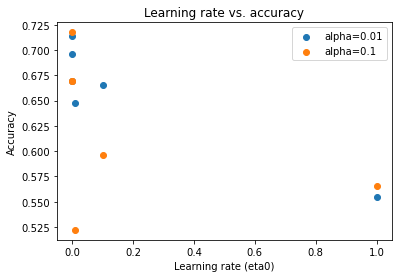

In [185]:
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

sgd = SGDClassifier(loss="log", penalty="l2", max_iter=50000, random_state=100)

param_grid = {
  'eta0': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
  'learning_rate': ['constant'],
  'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
}

grid_search = GridSearchCV(sgd, param_grid=param_grid)

grid_search.fit(X, y)

result = grid_search.cv_results_
estimator = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

mean_scores = result['mean_test_score']

scores_combo = {} # {[alpha_value]: { x: [eta0 values], y: [scores]}}

for idx, param in enumerate(result['params']):
    alpha = param['alpha']
    eta0 = param['eta0']
    score = mean_scores[idx]
    if scores_combo.get(alpha):
        scores_combo[alpha]['x'].append(eta0)
        scores_combo[alpha]['y'].append(score)
    else:
        scores_combo[alpha] = {'x': [eta0], 'y': [score]}
    

print(mean_scores)
print(scores_combo)
print('best score', best_score)
print('best params', best_params)

for key in scores_combo:
    if key == 0.1 or key == 0.01:
        values = scores_combo[key]
        label = f'alpha={key}'
        plt.scatter(values['x'], values['y'], label=label)
        
plt.title('Learning rate vs. accuracy')
plt.xlabel('Learning rate (eta0)')
plt.ylabel('Accuracy')

plt.legend()
plt.show()
